# Testing Navier-Stokes with a body and varying free stream in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [22]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [2]:
Re = 200; # Reynolds number

Set the free stream motion

In [17]:
U = 1.0; # Mean free stream velocity
σx = 0.1; # amplitude of velocity fluctuation 
ϕ = -π/2  # phase lag of pitch to heave
fstar = 1/π # fc/U

K = π*fstar # reduced frequency, K = πfc/U

oscil = RigidBodyMotions.OscilX(2π*fstar,U,U*σx,ϕ);
U∞ = RigidBodyMotion(oscil)

Rigid Body Motion:
  ċ = 0.9 + 0.0im
  c̈ = 0.0 + 0.0im
  α̇ = 0.0
  α̈ = 0.0
  Whirl.RigidBodyMotions.OscilX(2.0, 1.0, 0.1, -1.5707963267948966, Constant (0.0), AddedProfiles:
  Constant (1.0)
  0.1 × (Sinusoid (ω = 2.0) >> 0.7853981633974483)
, d/dt (AddedProfiles:
  Constant (1.0)
  0.1 × (Sinusoid (ω = 2.0) >> 0.7853981633974483)
))

Set up points on the body. Here is a plate:

In [4]:
n = 50;
body = Bodies.Plate(1.0,n)

Plate with 50 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [5]:
cent = 1.0 + 1.0im
α₀ = -15*π/180 # angle of attack
T = RigidTransform(cent,α₀)
T(body) # transform the body to the current configuration

Plate with 50 points and length 1.0 and thickness 0.0
   Current position: (1.0,1.0)
   Current angle (rad): 0.2617993877991494


Set up the domain

In [6]:
xlim = (0.0,4.0)
ylim = (0.0,2.0)

(0.0, 2.0)

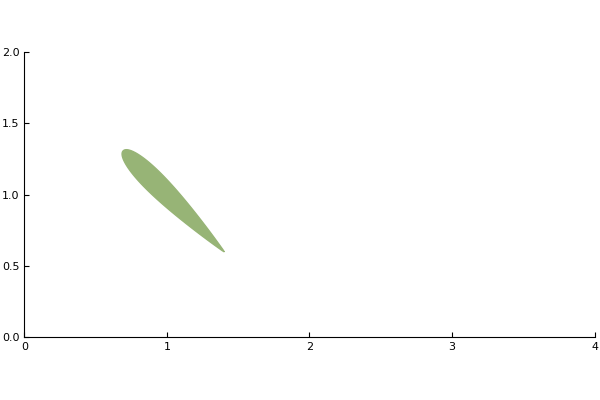

In [25]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [8]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Set the domain size and time step size

In [9]:
nx = 202; ny = 102;
Ly = ylim[2]-ylim[1];
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:2.0100000000000002)

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [11]:
u = w₀
f = VectorData(X̃);
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 202 x 102

In [16]:
U∞

LoadError: [91mUndefVarError: U∞ not defined[39m

Set up the integrator here

In [18]:
ifherk = IFHERK(u,f,sys.Δt,
                (t,u) -> Systems.plan_intfact(t,u,sys),
                (u,t) -> TimeMarching.plan_constraints(u,t,sys),
                ((u,t) -> Systems.r₁(u,t,sys,U∞),
                 (u,t) -> Systems.r₂(u,t,sys,U∞)),rk=TimeMarching.RK31,isstored=true)

Order-3 IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102}
   Force of type Whirl.Fields.VectorData{50}
   Time step size 0.01


Initialize the state vector and the history vectors

In [19]:
t = 0.0
w₀ .= 0.0
u = deepcopy(w₀)

fx = Float64[];
fy = Float64[];
thist = Float64[];

uhist = [];
tsample = 0.2; # rate at which to store field data

### Advance the system!

Set the time range to integrate over.

In [25]:
tf = 4.0;
T = Δt:Δt:tf;

In [26]:
@time for ti in T
    t, u, f = ifherk(t,u)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,u) : nothing
end
println("solution completed through time t = ",t)

 28.224925 seconds (6.75 M allocations: 3.930 GiB, 3.10% gc time)
solution completed through time t = 5.9999999999999165


#### Plotting

Basic plot

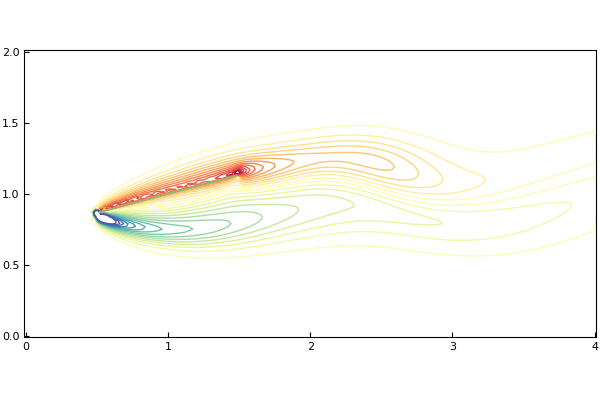

In [27]:
plot(xg,yg,uhist[end],levels=linspace(-0.25,0.25,30))
plot!(body)

Make a movie

In [28]:
@gif for i = 1:length(uhist)
    plot(xg,yg,uhist[i],levels=linspace(-0.5,0.5,30))
    plot!(body)
end

INFO: Saved animation to /Users/jeff/.julia/v0.6/Whirl/examples/tmp.gif


Plots.AnimatedGif("/Users/jeff/.julia/v0.6/Whirl/examples/tmp.gif")

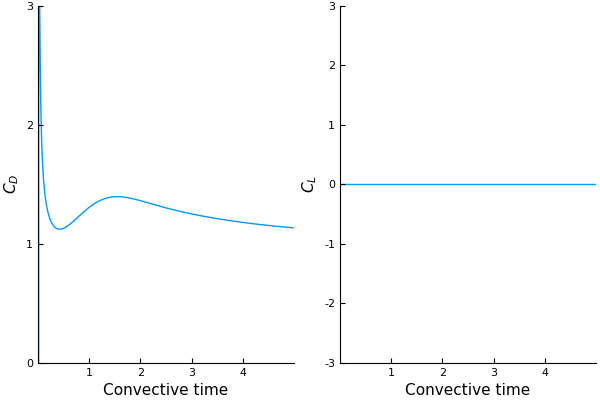

In [27]:
px = plot(thist,2*fx,ylim=(0,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-3,3),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

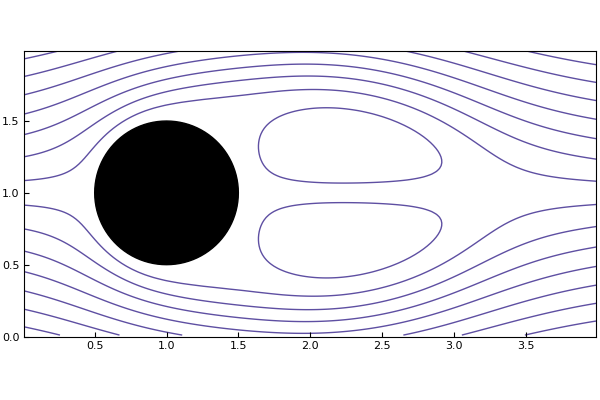

In [28]:
xg,yg = coordinates(u,dx=Δx)
ψ = deepcopy(u)
ψ .= -(sys.L\u)*Δx .+ repmat(collect(yg)',202,1)
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)

This isn't useful right now...

In [5]:
regopfilter = Regularize(X,Δx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(regopfilter,f,q);
Ẽmat = InterpolationMatrix(regopfilter,q,f);
P(f::VectorData) = Ẽmat*(H̃mat*f)